# **Sentiment analysis of IMDB using LSTM**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

In [6]:
import tensorflow as tf 
from keras.datasets import imdb
from keras import models
from keras import layers
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [7]:
max_features = 10000  # Only include top 10,000 words in the vocabulary
maxlen = 500  # Cut off each review after 500 words

In [8]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = max_features)

In [9]:
X_train.shape,  X_test.shape

((25000,), (25000,))

## Create map for converting IMDB dataset to readable reviews

Reviews in the IMDB dataset have been encoded as a sequence of integers. Luckily the dataset also 
contains an index for converting the reviews back into human readable form.

In [10]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Map for readable classnames
class_names = ["Negative", "Positive"]

# Ensure that "special" words are mapped into human readable terms 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [11]:
# Concatonate test and training datasets
allreviews = np.concatenate((X_train, X_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(X_train[8]))
print("  Review Sentiment: " + str(y_train[8]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(X_train[8]))
print("  Review Sentiment: " + class_names[y_train[8]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892

Machine readable Review
  Review Text: [1, 43, 188, 46, 5, 566, 264, 51, 6, 530, 664, 14, 9, 1713, 81, 25, 1135, 46, 7, 6, 20, 750, 11, 141, 4299, 5, 2, 4441, 102, 28, 413, 38, 120, 5533, 15, 4, 3974, 7, 5369, 142, 371, 318, 5, 955, 1713, 571, 2, 2, 122, 14, 8, 72, 54, 12, 86, 385, 46, 5, 14, 20, 9, 399, 8, 72, 150, 13, 161, 124, 6, 155, 44, 14, 159, 170, 83, 12, 5, 51, 6, 866, 48, 25, 842, 4, 1120, 25, 238, 79, 4, 547, 15, 14, 9, 31, 7, 148, 2, 102, 44, 35, 480, 3823, 2380, 19, 120, 4, 350, 228, 5, 269, 8, 28, 178, 1314, 2347, 7, 51, 6, 87, 65, 12, 9, 979, 21, 95, 24, 3186, 178, 11, 2, 14, 9, 24, 15, 20, 4, 84, 376, 4, 65, 14, 127, 141, 6, 52, 292, 7, 4751, 175, 561, 7, 68, 3866, 137, 75, 2541, 68, 182, 5, 235, 175, 333, 19, 98, 50, 9, 38, 76, 724, 4, 6750, 15, 166, 285, 36, 140, 143, 38, 76, 53, 3094, 1301, 4, 6991, 16, 82, 6, 87, 3578, 44, 2527, 7612, 5, 800, 4, 3033, 11, 35, 1728, 96, 21, 14, 22, 9,

## Data Pre-processing

We need to make sure that our reviews are of a uniform length. This is for the LSTM's parameters.

Some reviews will need to be truncated, while others need to be padded.

In [12]:
# Padding the data so that each sequence is of exactly 500 words

X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

In [13]:
X_train.shape,  X_test.shape

((25000, 500), (25000, 500))

## Building the Model

In [14]:
model = models.Sequential()
model.add(layers.Embedding(input_dim = max_features, # The size of our vocabulary 
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = maxlen))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(32))  # return_sequences = False
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Visualize the Model

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


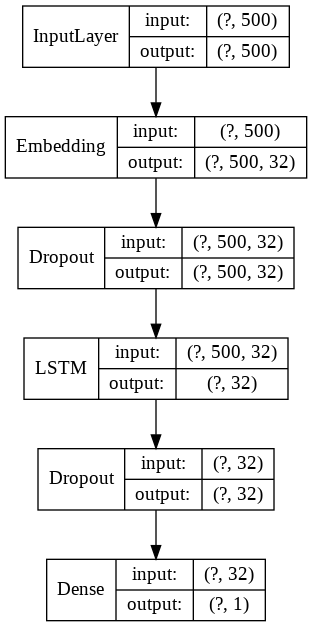

In [16]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=False)

## Train the LSTM

**Batch size: Number of samples to work through before updating the 
internal model parameters via back propagation. The higher the batch, the more memory you need.**

**The Embedding Layer provides a spatial mapping (or Word Embedding) of all the individual words in our training set. Words close to one another share context or meaning. This spatial mapping is learning during the training process.**

In [17]:
%%time
history = model.fit(X_train, y_train, batch_size = 256, epochs = 10, validation_split = 0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.5784 - accuracy: 0.6959 - val_loss: 0.4598 - val_accuracy: 0.7862
Epoch 2/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.3140 - accuracy: 0.8781 - val_loss: 0.2930 - val_accuracy: 0.8788
Epoch 3/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.2147 - accuracy: 0.9226 - val_loss: 0.2945 - val_accuracy: 0.8886
Epoch 4/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.1628 - accuracy: 0.9444 - val_loss: 0.2946 - val_accuracy: 0.8844
Epoch 5/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.1306 - accuracy: 0.9571 - val_loss: 0.4063 - val_accuracy: 0.8694
Epoch 6/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.1237 - accuracy: 0.9597 - val_loss: 0.3373 - val_accuracy: 0.8808
Epoch 7/10
20000/20000 [==============================] - 101s 

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

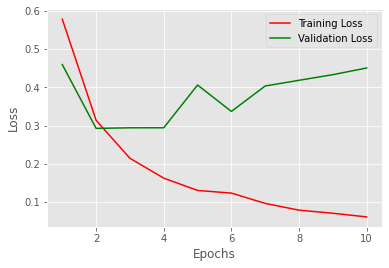

In [19]:
# Plotting Training and Validation Loss

epochs = range(1, 11)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

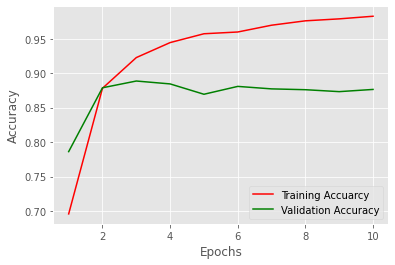

In [20]:
# Plotting Training and Validation Accuracy

plt.plot(epochs, acc, 'r', label = 'Training Accuarcy')
plt.plot(epochs, val_acc, 'g', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate model with test data and view results

In [21]:
# Testing

model.evaluate(X_test, y_test)

25000/25000 [==============================] - 67s 3ms/step


[0.5011011620527506, 0.8595600128173828]

In [22]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
predicted_classes = model.predict_classes(X_test)
print(classification_report(y_test, predicted_classes))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


              precision    recall  f1-score   support

           0       0.85      0.87      0.86     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



Test confusion matrix


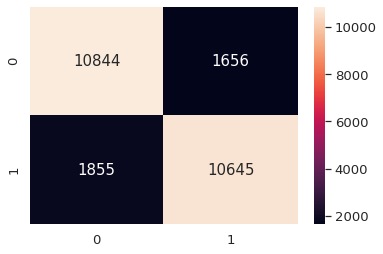

In [23]:
print("Test confusion matrix")
cm = confusion_matrix(y_test, predicted_classes)

sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, annot_kws={"size": 15}, fmt='g')

In [24]:
# classify sentiments (Positive or Negative) from review 

word_to_id = imdb.get_word_index()
review1 = "professional disappointment"    # review 1
review2 = "i really liked the movie and had fun"   # review 2
print("Evaluate the reviews")
print("====================")
for review in [review1,review2]:
  tmp = []
  for word in review.split(" "):
      tmp.append(word_to_id[word])
      tmp_padded = pad_sequences([tmp], maxlen = maxlen) 
  pred = model.predict(np.array([tmp_padded][0]))[0][0]
  if pred >= 0.5:
    sentiment = 'Positive'
  else:
    sentiment = 'Negative'
  print("%s : %s" % (review,sentiment))

Evaluate the reviews
professional disappointment : Negative
i really liked the movie and had fun : Positive
